<a href="https://colab.research.google.com/github/karchx/ml_101/blob/main/nlp_polizas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!java --version

In [2]:
!pip install tabula-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 19.6 MB/s eta 0:00:00


In [2]:
import tabula
import numpy
import os

tabula.environment_info()
numpy.__version__

os.path.abspath("")


Python version:
    3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Java version:
    openjdk version "11.0.25" 2024-10-15
OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
tabula-py version: 2.10.0
platform: Linux-6.1.85+-x86_64-with-glibc2.35
uname:
    uname_result(system='Linux', node='1071ae06d4a8', release='6.1.85+', version='#1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024', machine='x86_64')
linux_distribution: ('Ubuntu', '22.04', 'jammy')
mac_ver: ('', ('', '', ''), '')


'/content'

In [ ]:
!pip freeze | grep openpyxl

openpyxl==3.1.5


In [3]:
import tabula
import pandas as pd

def extract_data(path: str):
    dfs = tabula.read_pdf(path, stream=True, pages=0)
    df = dfs[0]
    df.columns = [f"column_{i}" for i in range(len(df.columns))]

    columns = []
    values = []

    for col in df.columns:
        for cell in df[col].dropna():
            # GET Poliza
            if "Póliza" in cell:
              parts = cell.split(" ")
              if len(parts) == 2:
                key, value = parts
                columns.append(key.strip())
                clean_value = value.replace("No.", "").strip()
                values.append(clean_value)

            if "Q" in cell:
                parts = cell.split("Q ")
                if len(parts) == 2:
                    key, value = parts
                    columns.append(key.strip())
                    values.append(value.strip())

    # Get Suma asegurada
    # TODO: validar que traiga data sino da un IndexError
    # df_suma = df[df['column_0'] == "Suma Asegurada:"]
    # key = df_suma['column_0'].values.astype(str)[0]
    # key = key.replace(":", "").strip()
    # value = df_suma['column_1'].values.astype(str)[0]
    # value = value.replace("Q.", "").strip()
    # columns.append(key.strip())
    # values.append(value.strip())

    df_final = pd.DataFrame(columns=columns, data=[values])

    print(df_final.to_json(orient="records", force_ascii=False))

In [111]:
import tabula
import pandas as pd
import re

keywords = ["PRIMA", "IVA", "GASTOS", "TOTAL", "SUMA", "Gtos"]

def extract_data(path: str):
    dfs = tabula.read_pdf(path, stream=True, multiple_tables=True)
    results = []
    clean_blank_space = re.compile(r'\s+')

    for df in dfs:
      df = df.astype(str)

      for index, row in df.iterrows():
        row_text = " ".join(row)
        row_text = row_text.replace("nan", "")

        if any(keyword in row_text.upper() for keyword in keywords):
          parts = row_text.split()

          for i, part in enumerate(parts):
            if part.upper() in keywords:
              if i + 1 < len(parts):
                value_re = [ s for s in parts if re.match(r'\d', s)]
                #print(f"{part} {value_re}")
                if len(value_re) > 0:
                  value = value_re[0]
                results.append((part, value))

    df = pd.DataFrame(results, columns=["Rubro", "Valor"])
    #print(df)


In [ ]:
!pip install PyMuPDF camelot-py tabula-py

In [187]:
import fitz  # PyMuPDF
import camelot


def extract_tables_from_pdf(pdf_path):
    tables = camelot.read_pdf(pdf_path, flavor='stream', edge_tol=500)
    return tables


def extract_data(pdf_path: str):
    tables = extract_tables_from_pdf(pdf_path)
    plt = camelot.plot(tables[0], kind='contour')
    plt.show()
    for table in tables:
        df = table.df
        print(df.iloc[0, 0])
        if "Suma" in df.iloc[0, 0]:
            print(df[0])

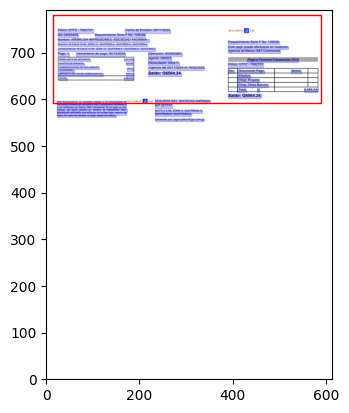

In [186]:
pdf_path = "./test2.pdf"
extract_data(pdf_path)

In [179]:
!pip install pytesseract
#https://gist.github.com/jasalt/f843566fc3fd6cac5a8af07930387181

In [ ]:
import re

In [ ]:
def show_image(item, title=""):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: any PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and using matplotlib
    to show it inline of the notebook.
    """
    DPI = 150  # use this resolution
    import numpy as np
    import matplotlib.pyplot as plt

    # %matplotlib inline
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set title of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))

In [ ]:
import fitz  # import PyMuPDF
if not hasattr(fitz.Page, "find_tables"):
    raise RuntimeError("This PyMuPDF version does not support the table feature")

In [ ]:
def extract_text_from_pdf(file_path: str):
    doc = fitz.open(file_path)
    text = ""
    for page in doc:
        text += page.get_text() + "\n"
    return text


In [ ]:
# TESTING

doc = fitz.open("./test_extract.pdf")
page = doc[26]

text = page.get_text("text")
pattern = r"([\w\s\.]+)Q\s+([\d,]+\.\d{2})"

matches = re.findall(pattern, text)

table_data = {item[0].strip(): float(item[1].replace(",", "")) for item in matches}
for key, value in table_data.items():
    print(f"{key}: Q {value}")

# tabs = page.find_tables()  # detect the tables
# for i,tab in enumerate(tabs):  # iterate over all tables
#     for cell in tab.header.cells:
#         print(cell)
#         page.draw_rect(cell,color=fitz.pdfcolor["red"],width=0.3)
#     page.draw_rect(tab.bbox,color=fitz.pdfcolor["green"])
#     print(f"Table {i} column names: {tab.header.names}, external: {tab.header.external}")
#
# show_image(page, f"Table & Header BBoxes")

1038
Requerimiento Serie E      No. 979476310
Total a Pagar: Q 189438.4


In [ ]:
tab = tabs[0]
df = tab.to_pandas()
df

,No.,Documento Pago,Monto,Col3
0,,Efectivo,,
1,,Chqs. Propios,,
2,,Chqs. Otros Bancos,,
3,,Total,"189,438",.40


In [ ]:
data = {}
text = extract_text_from_pdf("./test_extract.pdf")
lines = text.split('\n')

for i, line in enumerate(lines):
  if "PRIMA" in line:
    data["Prima"] = lines[i + 1].split()[-1].replace(",", "")
#print(text)
print(lines)